In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
mat_data = scipy.io.loadmat('Urban_R162.mat')
for key in mat_data:
    print(key)
t2 = mat_data['SlectBands']
t3 = mat_data['nRow']
t4 = mat_data['nCol']
t5 = mat_data['nBand']
hyperspectral_data = mat_data['Y']####################

end=scipy.io.loadmat('end5_groundTruth.mat')
for k in end:
    print(k)

e1=end['cood']
abundance_gt=end['A']
endmember_gt=end['M']######################
e4=end['nEnd']
e5=end['nRow']
e6=end['nCol']
print(e1)

__header__
__version__
__globals__
SlectBands
nRow
nCol
nBand
Y
maxValue
__header__
__version__
__globals__
cood
A
M
nEnd
nRow
nCol
[[array(['1-Asphalt Road'], dtype='<U14')]
 [array(['2-Grass'], dtype='<U7')]
 [array(['3-Tree'], dtype='<U6')]
 [array(['4-Roof'], dtype='<U6')]
 [array(['5-Dirt'], dtype='<U6')]]


In [2]:
import numpy as np
import pywt
from scipy.io import loadmat


# Load and normalize the hyperspectral cube
#file_path = '5e128x128SphericGFDefaultSNR40.mat'
#data = loadmat(file_path)
hyperspectral_data = hyperspectral_data.T
#synthetic_image = synthetic_image / np.max(synthetic_image)


# Reshape the data so that each pixel's spectral data is a 1D vector
vector_data = hyperspectral_data  # Shape: (307*307, 162)


# Perform wavelet transform on the first vector to get the coefficient sizes
sample_vector = vector_data[0]
cA, cD = pywt.dwt(sample_vector, 'bior1.3')  # Use the desired wavelet type


# Initialize cubes based on actual sizes of cA and cD
approximation_cube = np.empty((vector_data.shape[0], cA.shape[0]))
detail_cube = np.empty((vector_data.shape[0], cD.shape[0]))




In [3]:
hyperspectral_data.shape

(94249, 162)

In [4]:
# Apply wavelet transform to each 1D spectral vector and store coefficients in the cubes
for idx, vector in enumerate(vector_data):
    cA, cD = pywt.dwt(vector, 'bior1.3')  # Perform wavelet transform
    approximation_cube[idx, :] = cA
    detail_cube[idx, :] = cD


# Reshape the coefficient cubes back to spatial dimensions
#approximation_cube = approximation_cube.reshape(hyperspectral_data.shape[0], hyperspectral_data.shape[1], -1)
#detail_cube = detail_cube.reshape(hyperspectral_data.shape[0], hyperspectral_data.shape[1], -1)


# Output the shapes to verify
print("Shape of original cube:", hyperspectral_data.shape)
print("Shape of approximation cube:", approximation_cube.shape)
print("Shape of detail cube:", detail_cube.shape)




Shape of original cube: (94249, 162)
Shape of approximation cube: (94249, 83)
Shape of detail cube: (94249, 83)


In [5]:
import numpy as np
import pywt
from scipy.io import loadmat


# Load and normalize the hyperspectral cube
file_path = '5e128x128SphericGFDefaultSNR40.mat'
data = loadmat(file_path)
synthetic_image = data['syntheticImageNoisy']
end=data['endmembersGT']
synthetic_image = synthetic_image / np.max(synthetic_image)

end=endmember_gt.T
# Reshape the data so that each pixel's spectral data is a 1D vector
vector_data = end


# Perform wavelet transform on the first vector to get the coefficient sizes
sample_vector = vector_data[0]
cA, cD = pywt.dwt(sample_vector, 'bior1.3')  # Use the desired wavelet type


# Initialize cubes based on actual sizes of cA and cD
approximation = np.empty((vector_data.shape[0], cA.shape[0]))
detail = np.empty((vector_data.shape[0], cD.shape[0]))


# Apply wavelet transform to each 1D spectral vector and store coefficients in the cubes
for idx, vector in enumerate(vector_data):
    cA, cD = pywt.dwt(vector, 'bior1.3')  # Perform wavelet transform
    approximation[idx, :] = cA
    detail[idx, :] = cD


# Reshape the coefficient cubes back to spatial dimensions
#approximation_cube = approximation_cube.reshape(synthetic_image.shape[0], synthetic_image.shape[1], -1)
#detail_cube = detail_cube.reshape(synthetic_image.shape[0], synthetic_image.shape[1], -1)


# Output the shapes to verify
print("Shape of original cube:", end.shape)
print("Shape of approximation:", approximation.shape)
print("Shape of detail:", detail.shape)



Shape of original cube: (5, 162)
Shape of approximation: (5, 83)
Shape of detail: (5, 83)


In [6]:
print(approximation_cube.shape)
print(approximation.shape)

(94249, 83)
(5, 83)


In [7]:
app_cube=approximation_cube.T


# Reshape the data for the neural network
bands,height_width = app_cube.shape
data_for_nn = app_cube.reshape((bands,height_width))
data_for_nn = data_for_nn.astype(np.float64)
print(data_for_nn.dtype)

float64


In [8]:
# Convert to PyTorch tensors with explicit data type
data_tensor = torch.tensor(data_for_nn, dtype=torch.float32)  # Assuming float32 is appropriate
app=approximation.T
endmembers_gt_tensor = torch.tensor(app, dtype=torch.float32)

data_tensor_transposed = data_tensor.t()
endmembers_gt_tensor_transposed = endmembers_gt_tensor.t()

print(data_tensor_transposed.shape)
print(endmembers_gt_tensor_transposed.shape)


torch.Size([94249, 83])
torch.Size([5, 83])


In [9]:
# Assuming data_tensor has more samples than endmembers_gt_tensor
num_samples_to_keep =endmembers_gt_tensor_transposed.size(0)
print('num_samples_to_keep',num_samples_to_keep)



num_samples_to_keep 5


In [10]:
# Adjust the size of data_tensor
data_tensor_transposed = data_tensor_transposed[:num_samples_to_keep]
print('data')#5,431
print(data_tensor_transposed.shape)

data
torch.Size([5, 83])


In [11]:
# Combine data and ground truth endmembers into a single dataset
nn_dataset = TensorDataset(data_tensor_transposed,endmembers_gt_tensor_transposed)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Custom activation function
def custom_bior_activation(x):
    return F.relu(x) * torch.sin(5 * x) * torch.exp(-0.5 * torch.square(x))


# Define the CNN-based neural network model
class CNNEndmemberPredictionNet(nn.Module):
    def __init__(self, input_channels, output_size):
        super(CNNEndmemberPredictionNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)  # Added layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * (bands // 8), 256)
        self.fc2 = nn.Linear(256, output_size)

    def forward(self, x):
        x = custom_bior_activation(self.conv1(x))  # Replacing ReLU with custom activation
        x = self.pool(x)
        x = custom_bior_activation(self.conv2(x))  # Replacing ReLU with custom activation
        x = self.pool(x)
        x = custom_bior_activation(self.conv3(x))  # Replacing ReLU with custom activation
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = custom_bior_activation(self.fc1(x))  # Replacing ReLU with custom activation
        x = self.fc2(x)
        return x


In [13]:
print(app.shape)
# Instantiate the CNN model with a specified input_channels and output_size
input_channels = bands  # Assuming each band as a channel
print(input_channels)

cnn_model = CNNEndmemberPredictionNet(input_channels, app.shape[0])




# Define loss function and optimizer
criterion_mse = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Convert the data to a DataLoader
nn_loader = DataLoader(nn_dataset, batch_size=40, shuffle=True)

data_mean = torch.mean(data_tensor_transposed, dim=0)
data_std = torch.std(data_tensor_transposed, dim=0)

# Normalize the data
normalized_data = (data_tensor_transposed - data_mean) / data_std
normalized_dataset = TensorDataset(normalized_data, endmembers_gt_tensor_transposed)

# Adjust the size of normalized_data_tensor
normalized_data_tensor = normalized_data[:num_samples_to_keep]

# Create DataLoader with the normalized dataset
normalized_nn_loader = DataLoader(normalized_dataset, batch_size=40, shuffle=True)

(83, 5)
83


In [14]:

# Training loop
num_epochs = 2000 # Reduced the number of epochs
train_losses = []
for epoch in range(num_epochs):
    epoch_losses = []
    for inputs, targets in nn_loader:
        inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        
        # Compute the loss
        loss_mse = criterion_mse(outputs, targets)
        epoch_losses.append(loss_mse.item())

        # Mean Squared Error (MSE) Loss
        loss_mse = criterion_mse(outputs, targets)

        # Spectral Angle Mapper (SAM) Loss
        normalized_outputs = F.normalize(outputs, p=2, dim=1)
        normalized_targets = F.normalize(targets, p=2, dim=1)
        cos_similarity = F.cosine_similarity(normalized_outputs, normalized_targets, dim=1)
        loss_sam = 1 - cos_similarity.mean()

        # Spectral Information Divergence (SID) Loss
        epsilon = 1e-8
        loss_sid = torch.sum(targets * torch.log((targets + epsilon) / (outputs + epsilon)))
        
        # Spectral Angle Divergence (SAD) Loss
        sin_similarity = torch.sqrt(1 - cos_similarity**2)
        loss_sad = sin_similarity.mean()

        # Root Mean Squared Error (RMSE) Loss
        loss_rmse = torch.sqrt(loss_mse)
        
        # Calculate and store the average loss for the epoch
        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_epoch_loss)

        # Display losses
        print(f"Epoch {epoch + 1}/{num_epochs}, Batch Loss - MSE: {loss_mse.item():.12f}, SAM: {loss_sam.item():.12f}, SID: {loss_sid.item():.12f}, SAD: {loss_sad.item():.12f}, RMSE: {loss_rmse.item():.12f}")

        loss_mse.backward()
        optimizer.step()

# Evaluate the model on the entire dataset
with torch.no_grad():
    predictions = cnn_model(data_tensor_transposed.unsqueeze(1))  # Add a channel dimension

Epoch 1/2000, Batch Loss - MSE: 0.144619181752, SAM: 1.073792815208, SID: nan, SAD: 0.994096279144, RMSE: 0.380288302898
Epoch 2/2000, Batch Loss - MSE: 0.143694147468, SAM: 1.038693547249, SID: nan, SAD: 0.996329307556, RMSE: 0.379070103168
Epoch 3/2000, Batch Loss - MSE: 0.142572969198, SAM: 0.995262503624, SID: nan, SAD: 0.997336506844, RMSE: 0.377588361502
Epoch 4/2000, Batch Loss - MSE: 0.140990421176, SAM: 0.933006942272, SID: nan, SAD: 0.995475649834, RMSE: 0.375486910343
Epoch 5/2000, Batch Loss - MSE: 0.138670891523, SAM: 0.838504552841, SID: nan, SAD: 0.985141098499, RMSE: 0.372385412455
Epoch 6/2000, Batch Loss - MSE: 0.135048300028, SAM: 0.698276877403, SID: nan, SAD: 0.951870322227, RMSE: 0.367489188910
Epoch 7/2000, Batch Loss - MSE: 0.129627004266, SAM: 0.522182226181, SID: nan, SAD: 0.877542853355, RMSE: 0.360037505627
Epoch 8/2000, Batch Loss - MSE: 0.120617106557, SAM: 0.330391526222, SID: nan, SAD: 0.741746008396, RMSE: 0.347299724817
Epoch 9/2000, Batch Loss - MSE: 

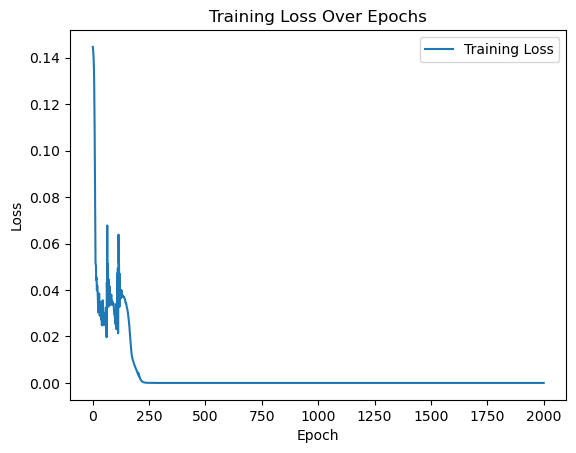

In [15]:
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

4


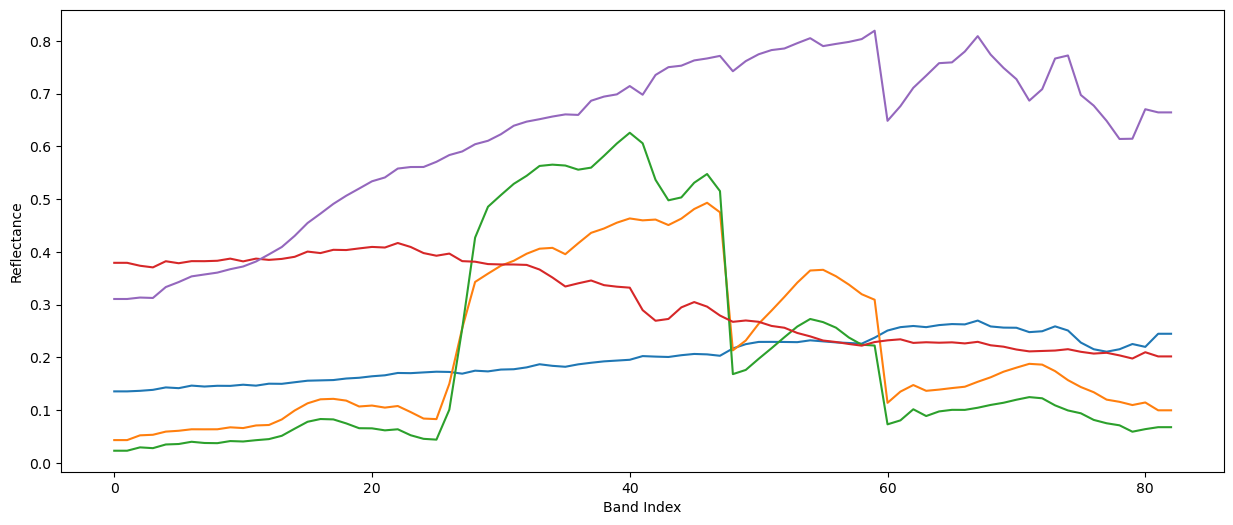

In [16]:
import matplotlib.pyplot as plt
# Visualize the predicted and ground truth endmembers
plt.figure(figsize=(15, 6))
for i in range(app.shape[1]):
    plt.plot(app[:,i], label=f'GT Endmember {i + 1} (Ground Truth)')
    #plt.plot(predictions[ i,:].numpy(), linestyle='solid', label=f'Predicted Endmember {i + 1}')
print(i)
#plt.title('Actual Ground Truth')
plt.xlabel('Band Index')
plt.ylabel('Reflectance')
#plt.legend()
plt.show()



In [17]:
a=[e1]
print(a)
b=['Asphalt Road','Grass','Tree','Roof','Dirt']

[array([[array(['1-Asphalt Road'], dtype='<U14')],
       [array(['2-Grass'], dtype='<U7')],
       [array(['3-Tree'], dtype='<U6')],
       [array(['4-Roof'], dtype='<U6')],
       [array(['5-Dirt'], dtype='<U6')]], dtype=object)]


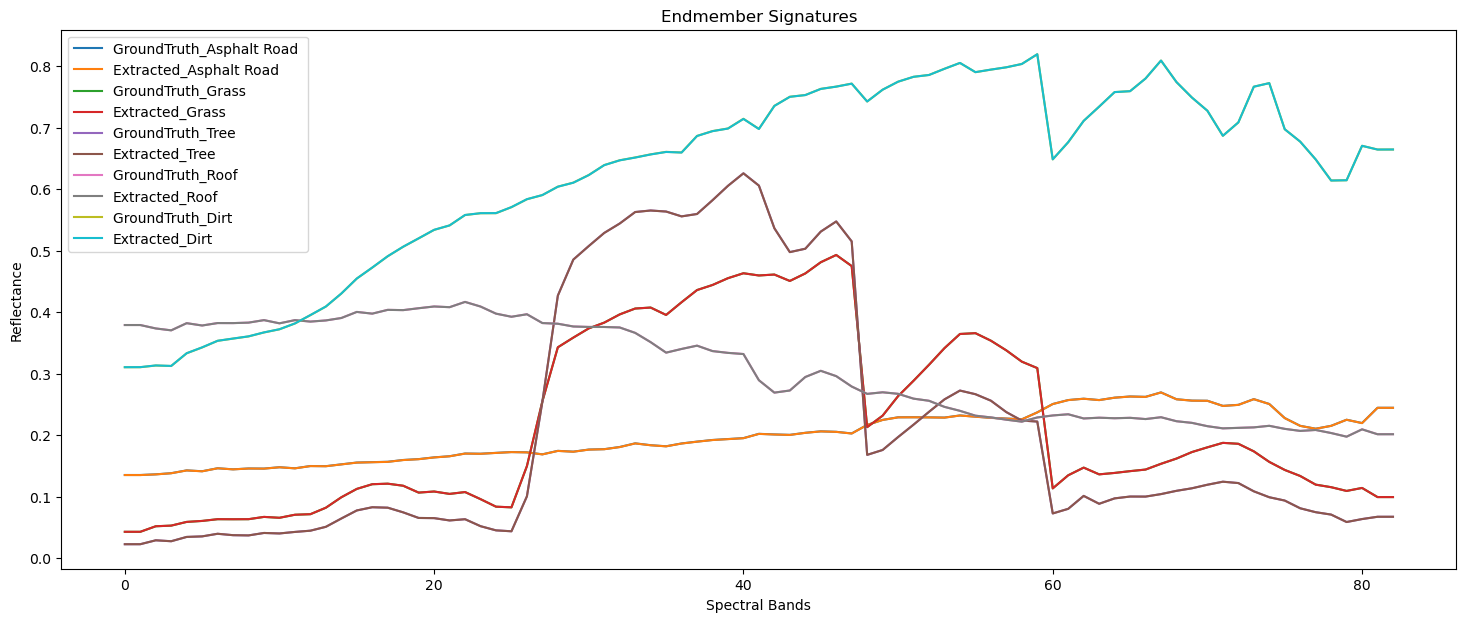

In [18]:
import matplotlib.pyplot as plt
# Visualize the predicted and ground truth endmembers
plt.figure(figsize=(18,7))
for i in range(app.shape[1]):
    plt.plot(app[ :,i], label=f'GroundTruth_{b[i]} ')
    plt.plot(predictions[ i, :].numpy(), linestyle='solid', label=f'Extracted_{b[i]}')
plt.title('Endmember Signatures')
plt.xlabel('Spectral Bands')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

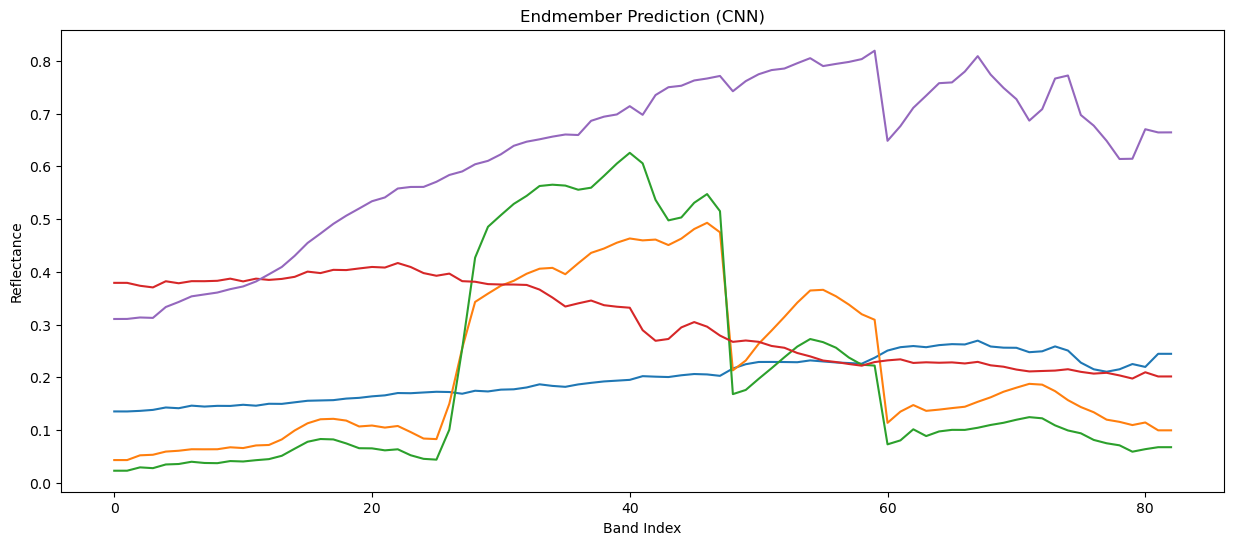

In [19]:
# Visualize the predicted and ground truth endmembers
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.plot(predictions[ i, :].numpy(), linestyle='solid', label=f'Predicted Endmember {i + 1}')

plt.title('Endmember Prediction (CNN)')

plt.xlabel('Band Index')
plt.ylabel('Reflectance')
#plt.legend()
plt.show()